# Machina Labs
## Homework/Problem Solution

Thank you for the opportunity to interview at Machina Labs. This was a really interesting dataset to work on and, in particular, it was instructive to model real world data.

I've tried to structure this jupyter notebook as cleanly as I could so that it is easy to follow different approaches I've tried. Also, for every model I trained I have stored a copy (as a pickle file) in the director `models`. This will allow you to see results without the need to personally re-train the models. For some methods (e.g. Neural Networks), the training time is quite long (especially without a dedicated GPU) so loading the model will be quick.

I've provided an environment.yml file with the necessary python packages. If you're using conda, you should be able to easily create a new environment with

```bash
conda env create -p machina_hw -f environment.yml
```

Here I'm creating a global variabled called `RETRAIN`. If this is set to True, running any cell with a trainable model will train a new model and replace the old one in the directory called `models`. If you want to skip the training and simply evaluate a pre-trained model, leave `RETRAIN` set to False.

In [1]:
RETRAIN = True

## Loading Initial Packages

To
start, let's load a few of common packages and jupyter magic commands. The rest of the modules will be imported as needed later on.

In [3]:
# Plotting support for jupyter
from IPython.display import display
from IPython.display import Video
%matplotlib notebook
%matplotlib inline

# Basic/Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np

# define a local home variable for pathlib
import pathlib
home = pathlib.Path.cwd()

# Some common paths we might use to store data/models/figures
data_path = home / "data"
model_path = home / "models"

## Analyzing Data
Let's load all of the data using pandas and store each of the 3 dataframes into a dictionary that we can loop through.

In [5]:
data = {}  # Store each dataframe in this dictionary with the filename as the key

# Loop through csv files and store the dataframe in 'data'
for file in home.glob("*.csv"):
    # Data is loaded with pandas and stored.
    data[file.stem] = pd.read_csv(file, index_col=["t"])

display(data["Test1"].head())  # display one of the dataframes

,a_enc_1,b_enc_1,c_enc_1,x_enc_1,y_enc_1,z_enc_1,a_enc_2,b_enc_2,c_enc_2,x_enc_2,y_enc_2,z_enc_2,fx_1,fy_1,fz_1,fx_2,fy_2,fz_2
t,,,,,,,,,,,,,,,,,,
1636579517,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2023,-179.8798,22.3221,783.1761,-772.5771,-2.326357,9.639795,-32.645949,11.805614,18.656085,-12.831012
1636579518,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.192611,9.531656,-33.073905,11.697159,18.462518,-12.250218
1636579519,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.103594,9.776526,-31.435784,11.662171,18.601191,-11.455588
1636579520,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-1.869649,9.100982,-31.719140,11.414681,18.489816,-12.538161
1636579521,-4.9511,0.0183,-0.0719,213.6337,324.1015,895.3528,-154.9772,0.2024,-179.8798,22.3204,783.1754,-772.5771,-2.336206,9.058406,-32.329481,11.223285,17.952984,-10.425429


This is timeseries data parameterized in time (t) with (x,y,z) positional data for tool tip \#1 (`x_enc_1`, `y_enc_1`, `z_enc_1`) and tool tip \#2 (`x_enc_2`, `y_enc_2`, `z_enc_2`). There is also Pitch/Yaw/Roll data for both tool tips (`a_enc_1`, `b_enc_1`, `c_enc_1`, `a_enc_2`, `b_enc_2`, `c_enc_2`) and force data (`fx_1`, `fy_1`, `fz_1`, `fx_2`, `fy_2`, `fz_2`)

So we want to be able to predict all of `y` given `X` where:
- X = [`a_enc_1`, `b_enc_1`, `c_enc_1`, `x_enc_1`, `y_enc_1`, `z_enc_1`, `a_enc_2`, `b_enc_2`, `c_enc_2`, `x_enc_2`, `y_enc_2`, `z_enc_2`]
- y = [`fx_1`,`fy_1`,`fz_1`,`fx_2`,`fy_2`,`fz_2`]

Let's plot the features and targets in time.

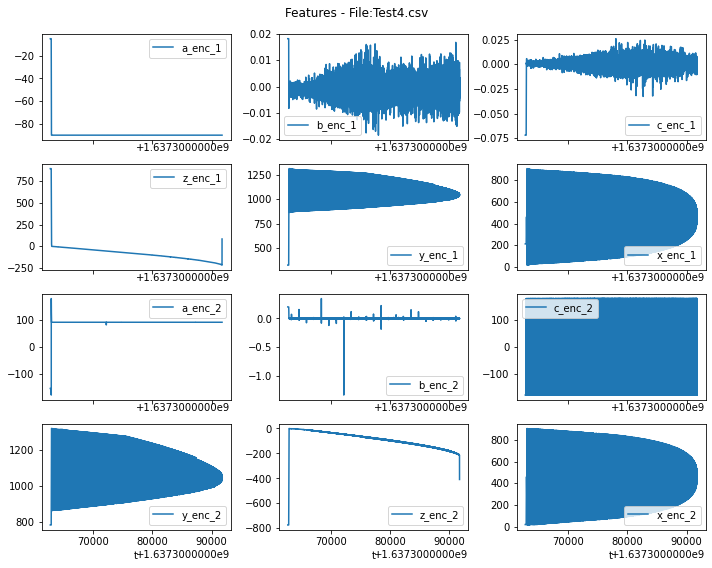

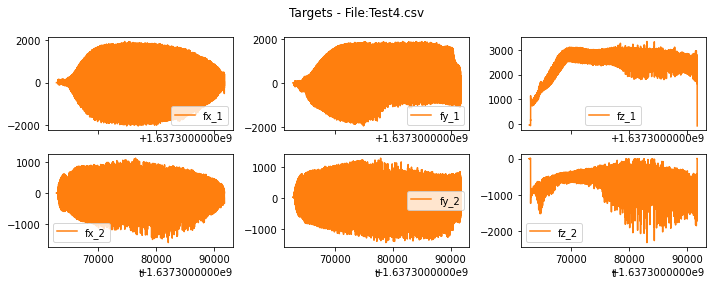

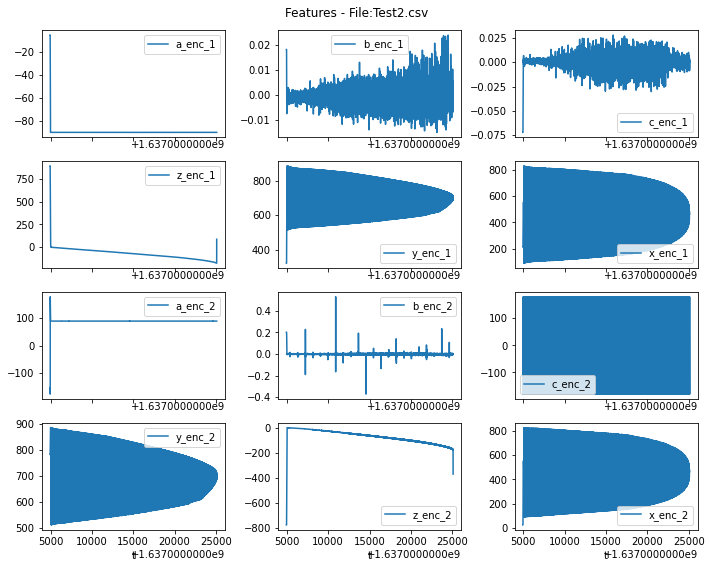

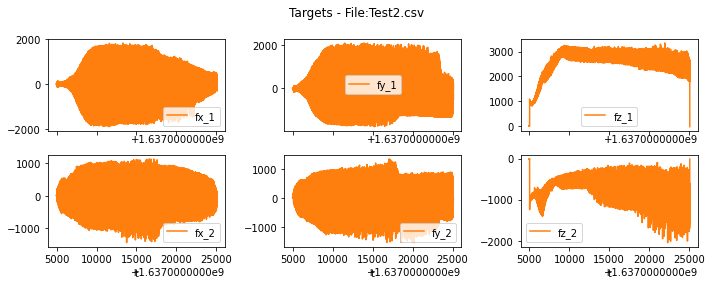

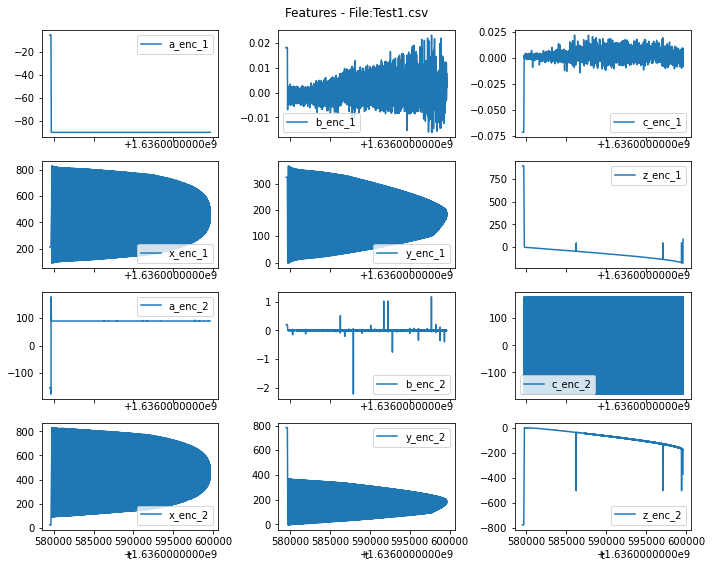

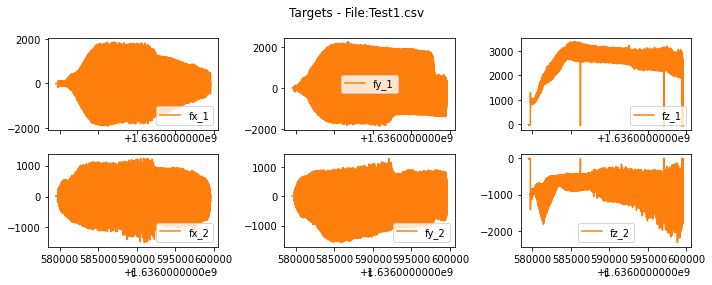

In [6]:
for key in data:  # Loop through all 3 test data sets
    df = data.get(key)
    Xdf = df.filter(regex=("enc*"))  # Filter features with regex using `enc`
    ydf = df.filter(regex=("fx*"))  # Filter targets with regex using `fx`

    # Plot features
    Xdf.plot(subplots=True, layout=(4,3), figsize=(10,8), color='tab:blue')
    plt.suptitle(f"Features - File:{key}.csv")
    plt.tight_layout()

    # Plot targets (forces)
    ydf.plot(subplots=True, layout=(2,3), figsize=(10,4), color='tab:orange')
    plt.suptitle(f"Targets - File:{key}.csv")
    plt.tight_layout()

Looking over the timeseries plots, some observations I have are:
1. The tool `pitch` (a_enc_1 and a_enc_2) remains fixed throughout operation. This likely won't be a particularly useful feature for training. Additionally, the z-component and Euler angle `b_enc_2` contain relatively little varied data and so, for this part at least, will probably not contribute too much to the model. It would be interesting, given more time, to run these features through something like a feature selection via Lasso regression or Shapley Analysis (on a boosted decision tree) to see how much something like `z_enc_1` contributes to predictions
2. Comparing the (x,y,z) coordinate data for both tooltips, the 3 datasets look like they represent a similar set of tool paths but not identical. The change between tests is almost certainly a systematic change so the model will need to learn not only how to predict forces from tool positioning but also how those forces change as a function of variations in the part geometry.
3. The data seems to capture the initial arm movements (i.e. when the tools are being moved into position). This explains the sharp spike present at the beginning of all the (a,b,c), the (x,y,z) measurements and the force=0 values. We could, in theory, "clean up" some of those starting/ending movements. However, it would be beneficial to just have the model learn what this looks like and fold it into the predictions.
4. Additionally, the force in the z-axis drops to zero occasionally, which is presumably a time when the arms are being re-positioned. This, again, is something the model should capture and so it might be counter-productive to try and "clean up" those events.

Although not too informative, I'd like to see a 3D parameteric plot of the tool tip path (x,y,z) information to compare to the video.

## Example Video

In [8]:
# Video of the tool tip video for Test4
Video("Test4_trim.mp4", width=1920//2, height=1080//2)

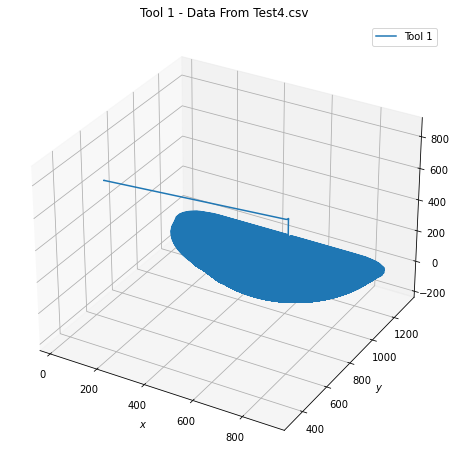

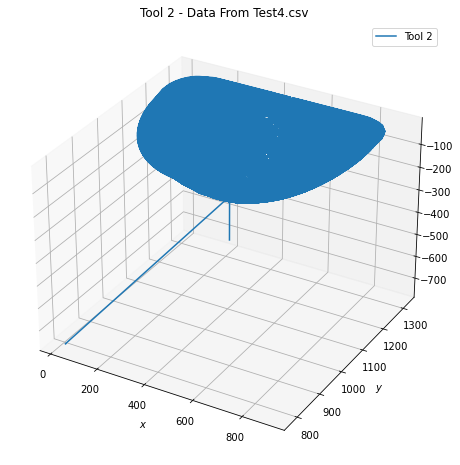

In [9]:
for tn in range(1,3): # Loop through both tools with tool_number (tn) 1 and 2
    df = data["Test4"] # Let's just look at Test4 data
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    ax.plot(df.get(f"x_enc_{tn}"),
            df.get(f"y_enc_{tn}"),
            df.get(f"z_enc_{tn}"),
            label=f'Tool {tn}',
            )
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.legend()
    ax.set_title(f"Tool {tn} - Data From Test4.csv")